In [1]:
import numpy as np
from scipy.stats import multivariate_normal as N
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd

def plot_gaussian_mixture(mu, cov, P, X = None, granularity = 50):
    
    if len(mu[0]) > 2:
        raise Exception("Plotting supported only for 2D data.")
    if len(mu) != len(cov):
        raise Exception("mu and cov don't have same length")
    if len(mu) != len(P):
        raise Exception("mu and P don't have same length")
    
    # set up mixted density function (slide 16)
    f = lambda x: sum([N.pdf(x, mu[i], cov[i]) * P[i]  for i in range(len(mu))])
          
    # create grid
    min_x1, max_x1 = np.inf, -np.inf
    min_x2, max_x2 = np.inf, -np.inf
    span = 5
    for i in range(len(mu)):
        min_x1 = min(min_x1, mu[i][0] - span * cov[i][0,0])
        min_x2 = min(min_x2, mu[i][1] - span * cov[i][1,1])
        max_x1 = max(max_x1, mu[i][0] + span * cov[i][0,0])
        max_x2 = max(max_x2, mu[i][1] + span * cov[i][1,1])
    min_x1 -= 1
    min_x2 -= 1
    max_x1 += 1
    max_x2 += 1
    X1 = np.linspace(min_x1, max_x1, granularity)
    X2 = np.linspace(min_x2, max_x2, granularity)
    Z = np.zeros((granularity, granularity))
    
    # compute densities in grid
    M_X1, M_X2 = np.meshgrid(X1, X2)
    for i in range(granularity):
        for j in range(granularity):
            x1, x2 = M_X1[i,j], M_X2[i,j]
            Z[i,j] = f([x1,x2])
    
    # create 3D plot with surface
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 10))
    ax.plot_wireframe(M_X1, M_X2, Z, linewidth=1,alpha=0.6)
    ax.set_xlim(min_x1, max_x1)
    ax.set_ylim(min_x2, max_x2)
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    
    # scatter the points into the plot
    if X is not None:
        ax.scatter(X[:,0], X[:,1], 0)

# Exercise 2

## Plots
### Dependent

In [5]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import random
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal

def EM(A, k, eps, mu=None, cov=None, independent=False):

    # Initialization step
    centroids = []
    covariances = []
    if mu is None:
        centroids = [[random.choice(A[:, 0]), random.choice(A[:, 1])]
                     for x in range(k)]
    else:
        centroids = mu

    A_rows, A_cols = A.shape
    if cov is None:
        covariances = [np.identity(A_cols) for x in range(k)]
    else:
        covariances = cov

    prior_probs = [1/k for x in range(k)]

    w = np.empty([A_rows, k])
    while True:
        total = 0
        old_centroids = centroids
        # Expectation step
        for i in range(0, k):
            for j in range(0, A_rows):
                wij_abajo = 0
                punto = [A[j]]
                b = centroids[i]
                c = covariances[i]
                wij_arriba = ((multivariate_normal.pdf(punto, mean=b, cov=c))*prior_probs[i])
                for a in range(0, k):
                    wij_abajo += (multivariate_normal.pdf(punto, mean=centroids[a], cov=covariances[a]))*prior_probs[a]

                w[j, i] = wij_arriba/wij_abajo

        # Maximization step
        #print(centroids)
        centroids = []
        prior_probs = []
        for i in range(0, k):
            muti_arriba = 0
            muti_abajo = 0
            covi_arriba = 0
            centroid_prob = []
            for j in range(0, A_rows):
                punto = np.array(A[j])
                # re-estimate mean
                muti_arriba += (w[j, i]*punto)
                muti_abajo += w[j, i]
                muti = muti_arriba/muti_abajo
                # re-estimate covariance matrix diagonals (variance)
                covi_arriba += w[j, i]*(punto-muti)*((punto-muti).T)
            covi = covi_arriba/muti_abajo
                # re-estimate priors
            pti = muti_abajo/A_rows
            centroids.append(muti)
            np.fill_diagonal(covariances[i], covi)
            prior_probs.append(pti)

        print(centroids)
        print("cambio",w)
        #Dependent Cov
        if independent == False:
            cov_nuevo = np.empty([A_cols, A_cols])
            for i in range(0, k):
                # re-estimate covariance matrix anti-diagonals (covariance)
                covab = 0
                covab_arriba = 0
                muti_abajo = 0
                for j in range(0, A_rows):
                    muti_abajo += w[j, i]
                    print(w[j, i], ' * ' , A[j, 0],  ' - ', centroids[i][0], ' * ', A[j, 1], ' - ' ,centroids[i][1])
                    covab_arriba += w[j, i] * (A[j, 0] - centroids[i][0]) * (A[j, 1] - centroids[i][1])
                    # for a in range(0, A_cols):
                    #     if a == (A_cols-1):
                    #         covab_arriba += w[j, i] * (A[j, a-1]-centroids[i][a-1]) * (A[j, a]-centroids[i][a])
                    #     else:
                    #         covab_arriba += w[j, i] * (A[j, a]-centroids[i][a]) * (A[j, a+1]-centroids[i][a+1])
                covab = covab_arriba/muti_abajo
                print("covab",covab)
                np.fill_diagonal(cov_nuevo, covab)
                cov_nuevo =  np.fliplr(cov_nuevo)
                #print(covariances[i])
                covariances[i] = cov_nuevo + covariances[i]
                #print(covariances[i])
                
        for s in range(k):
            total += (centroids[s] - old_centroids[s])**2
        if (total[0] <= eps and total[1] <= eps):
            break
    return w, centroids, covariances, prior_probs

#%matplotlib notebook
Iris_pca = pd.read_csv("iris_pca.csv").values
mu_init = [np.array(mu) for mu in [[-3.59, 0.25], [-1.09, -0.46], [0.75, 1.07]]]
cov_init = [np.eye(2) for i in range(3)]
probs, mu, cov, P = EM(Iris_pca, 3, 0.001, mu=mu_init, cov=cov_init, independent=False)
print(np.round(mu, 2), np.round(cov, 2), np.round(P, 2))
plot_gaussian_mixture(mu, cov, P, Iris_pca)

[array([-2.65889404,  0.19071151]), array([-0.76362906, -0.25280137]), array([1.63451792, 0.03824792])]
cambio [[7.60766838e-01 2.36835999e-01 2.39716310e-03]
 [7.08513967e-01 2.90187886e-01 1.29814703e-03]
 [7.93831920e-01 2.05467585e-01 7.00494720e-04]
 [7.03985275e-01 2.95011020e-01 1.00370491e-03]
 [7.81380637e-01 2.16576429e-01 2.04293399e-03]
 [6.02394335e-01 3.82104122e-01 1.55015427e-02]
 [7.71055322e-01 2.27984495e-01 9.60183242e-04]
 [7.11548929e-01 2.85916955e-01 2.53411565e-03]
 [7.38351665e-01 2.61187988e-01 4.60347181e-04]
 [6.95954793e-01 3.02437335e-01 1.60787200e-03]
 [7.17260750e-01 2.76358410e-01 6.38084088e-03]
 [6.82542211e-01 3.15178116e-01 2.27967273e-03]
 [7.36501081e-01 2.62557813e-01 9.41105805e-04]
 [8.73157763e-01 1.26709096e-01 1.33141446e-04]
 [8.36959082e-01 1.56674243e-01 6.36667553e-03]
 [7.42458464e-01 2.37690174e-01 1.98513621e-02]
 [7.92151603e-01 2.02967043e-01 4.88135382e-03]
 [7.42941000e-01 2.54340207e-01 2.71879303e-03]
 [5.72129036e-01 4.045827

ValueError: The input matrix must be symmetric positive semidefinite.

### Independent

[[-2.64  0.19]
 [ 0.41 -0.52]
 [ 1.85  0.15]] [[[0.05 0.  ]
  [0.   0.2 ]]

 [[0.38 0.  ]
  [0.   0.08]]

 [[0.63 0.  ]
  [0.   0.13]]] [0.33 0.24 0.42]


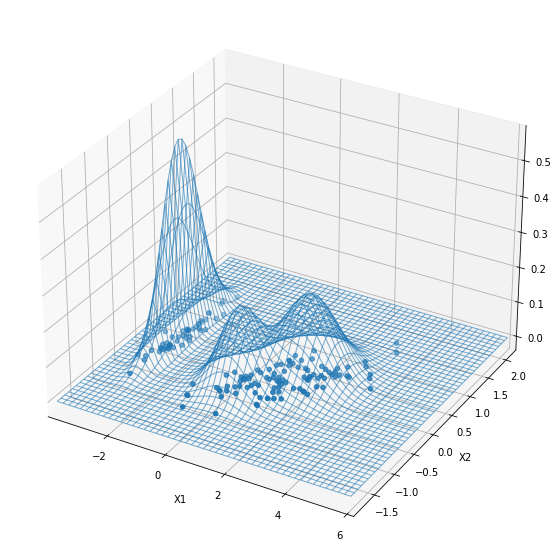

In [3]:
#%matplotlib notebook
Iris_pca = pd.read_csv("iris_pca.csv").values
mu_init = [np.array(mu) for mu in [[-3.59, 0.25], [-1.09, -0.46], [0.75, 1.07]]]
cov_init = [np.eye(2) for i in range(3)]
probs, mu, cov, P = EM(Iris_pca, 3, 0.001, mu=mu_init, cov=cov_init, independent=True)
print(np.round(mu, 2), np.round(cov, 2), np.round(P, 2))
plot_gaussian_mixture(mu, cov, P, Iris_pca)